# Good Crop Bad Crop

### Mask creation

Initial mask creation done manually with the possibility of creating masks using a tool in the future. (One field mask creation)

Issues:
- Different fields will have different pixel counts, need to compress last fields/expand small fields.  Suggestion: Analyse fields across dataset and determine average size in pixels, initially just use chosen field size

In [17]:
#imports
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from datetime import datetime
import copy
from sklearn.preprocessing import MinMaxScaler

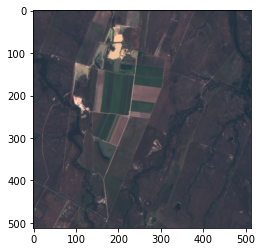

In [2]:
tile_x = 5120
tile_y = 3584
band = 'TCI' #photo
time_period = '2019-07-20'
TCI_filename = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-{band}-{time_period}.png"
mask_filename = f"./satelite_data/Phase02DataDelivery/masks/mask-x{tile_x}-y{tile_y}.png"

TCI_image = image.imread(TCI_filename)
plt.imshow(TCI_image)

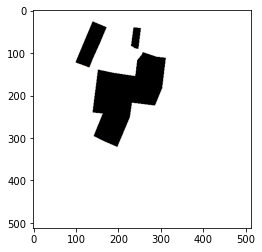

In [3]:
mask_image = image.imread(mask_filename)
plt.imshow(mask_image)

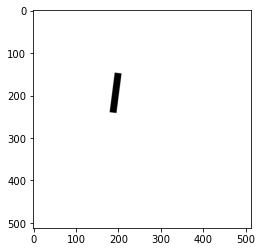

In [4]:
# manually created in photoshop a mask for a single field:

field_mask_filename = f"./satelite_data/{tile_x}-{tile_y}-SingleFieldMask.png"
field_mask_image = image.imread(field_mask_filename)
plt.imshow(field_mask_image)

In [5]:
field_mask_image = field_mask_image[:,:,-1].reshape(512,512,1)

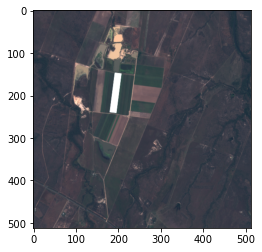

In [6]:
plt.imshow(np.minimum(TCI_image + field_mask_image,1))

In [7]:
#now that we have a mask, let us load all of the related image, and store them in a dataframe with each row being a date

location_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-{band}*.png"
location_times = glob.glob(location_path)

for i in range(0,len(location_times)):
    location_times[i] = location_times[i][-14:-4]
    
        

In [8]:
df = pd.DataFrame()

bool_mask = (field_mask_image == 1.0).reshape(512,512)

colour_names = ['R','G','B','A']
mask_pixels = np.sum(bool_mask)

for time_period in location_times:
    row_dict = {'Time': datetime.strptime(time_period, '%Y-%m-%d')}
    for i in range(1,13):
        file_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B{i:02d}-{time_period}.png"
        image_file = image.imread(file_path)
        
        ravel_pixels = image_file[bool_mask].ravel()
        layer_count = ravel_pixels.shape[0]/mask_pixels
        field_pixels = np.median(ravel_pixels)
        if(layer_count == 1):
            row_dict[f'B{i:02d}'] = np.median(ravel_pixels)
        else:
            ravel_pixels = ravel_pixels.reshape(-1,layer_count)
            for j in range(0,layer_count):
                row_dict[f'B{i:02d} L{j}'] = np.median(ravel_pixels[:,j])

    # add TCI
    file_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-TCI-{time_period}.png"
    image_file = image.imread(file_path)
    
    ravel_pixels = image_file[bool_mask].ravel()
    layer_count = int(ravel_pixels.shape[0]/mask_pixels)
    ravel_pixels = ravel_pixels.reshape(-1,layer_count)
    for j in range(0,layer_count):
        row_dict[f'TCI {colour_names[j]}'] = np.median(ravel_pixels[:,j])
    
    df = df.append(row_dict, ignore_index=True)


In [9]:
df.head(3)

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,TCI B,TCI G,TCI R,Time
0,0.047578,0.038697,0.034607,0.033478,0.037903,0.048463,0.055116,0.049683,0.014557,0.000397,0.056916,0.037293,0.360784,0.321569,0.309804,2017-09-28
1,0.043671,0.037903,0.036835,0.037720,0.044343,0.064668,0.074098,0.071199,0.022461,0.000519,0.075380,0.054932,0.352941,0.341176,0.349020,2018-08-14
2,0.047364,0.043061,0.041657,0.048890,0.053010,0.059846,0.066011,0.063813,0.022126,0.000427,0.085084,0.070985,0.400000,0.388235,0.450980,2018-06-05


In [10]:
df.describe()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,TCI B,TCI G,TCI R
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,0.065632,0.059615,0.057674,0.057903,0.064296,0.084879,0.096225,0.091550,0.027040,0.001063,0.084943,0.057442,0.491246,0.479039,0.473295
std,0.043054,0.044046,0.042293,0.046763,0.044402,0.041126,0.042276,0.039994,0.023638,0.001879,0.031685,0.027520,0.239762,0.236921,0.263744
min,0.036683,0.028992,0.022034,0.013031,0.015839,0.034333,0.042847,0.038209,0.005127,0.000244,0.017029,0.006622,0.270588,0.207843,0.125490
25%,0.042756,0.036164,0.034913,0.031342,0.040467,0.059586,0.066590,0.064622,0.015686,0.000366,0.061006,0.032959,0.335294,0.325490,0.292157
50%,0.047364,0.040955,0.040070,0.041230,0.048035,0.075349,0.088319,0.086152,0.020356,0.000427,0.080079,0.056764,0.380392,0.372549,0.384314
75%,0.066972,0.059022,0.056825,0.061402,0.066224,0.092760,0.112535,0.107027,0.027970,0.000595,0.101106,0.077501,0.545098,0.525490,0.566667
max,0.219150,0.212955,0.205203,0.219242,0.225071,0.228336,0.234440,0.228336,0.136019,0.008789,0.176028,0.116670,1.000000,1.000000,1.000000


### Prepare data for model

In [11]:
# order by date and max target variable following period

rows_before_shift = df.shape[0]
df.sort_values(by='Time', ignore_index=True, inplace=True)

df_copy = copy.deepcopy(df) #hack to not lose row from next line of code

In [15]:
df = copy.deepcopy(df_copy)  #hack for debugging, not needed

NDVI = (df['B08'] - df['B03'])/(df['B08'] + df['B03'])
NDVI_shift = np.append(np.array(NDVI[1:]),None)
time_shift = np.append(np.array(df['Time'][1:]),None)
df['NDVI'] = NDVI
df['TimeBetween'] = time_shift
df['TimeBetween'] = pd.to_datetime(df['TimeBetween']) - df['Time']
df['Target NDVI'] = NDVI_shift

df = df[:rows_before_shift-1].reset_index()

df['Time'] = df['Time'].dt.month
df['TimeBetween'] = df['TimeBetween'].astype('timedelta64[D]')
df

,index,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,TCI B,TCI G,TCI R,Time,NDVI,TimeBetween,Target NDVI
0,0,0.078279,0.069795,0.067720,0.071199,0.073915,0.090150,0.101076,0.093538,0.018616,0.000427,0.115145,0.082826,0.643137,0.627451,0.658824,12,0.160106,10.0,0.147815
1,1,0.051667,0.044251,0.040467,0.042084,0.041962,0.050294,0.058015,0.054505,0.008087,0.000336,0.057343,0.032807,0.411765,0.376471,0.392157,1,0.147815,10.0,0.175225
2,2,0.043610,0.036713,0.032105,0.031403,0.032898,0.042084,0.050477,0.045747,0.006561,0.000275,0.050721,0.028199,0.341176,0.298039,0.294118,1,0.175225,30.0,0.374745
3,3,0.044099,0.039124,0.042084,0.035798,0.050996,0.084321,0.098543,0.092531,0.015900,0.000336,0.090120,0.053162,0.364706,0.388235,0.333333,2,0.374745,10.0,0.428506
4,4,0.042481,0.034852,0.038178,0.024109,0.044282,0.085695,0.105653,0.095430,0.010101,0.000244,0.071473,0.031983,0.325490,0.352941,0.223529,2,0.428506,10.0,0.138491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,65,0.042695,0.033661,0.033631,0.020417,0.034180,0.085603,0.106508,0.100099,0.016571,0.000366,0.053315,0.021210,0.313726,0.313726,0.192157,6,0.497033,10.0,0.505859
66,66,0.037720,0.029847,0.030243,0.018891,0.033051,0.077943,0.094606,0.092164,0.030701,0.000305,0.049439,0.021180,0.278431,0.282353,0.176471,6,0.505859,10.0,0.470619
67,67,0.037873,0.030457,0.031342,0.020722,0.035035,0.075349,0.090639,0.087068,0.019806,0.000336,0.050660,0.021393,0.282353,0.290196,0.196078,6,0.470619,20.0,0.458915
68,68,0.037781,0.030335,0.031952,0.022065,0.038666,0.075990,0.088319,0.086152,0.028321,0.000366,0.050752,0.022614,0.282353,0.298039,0.207843,7,0.458915,10.0,0.425721


In [16]:
df.dtypes

index            int64
B01            float64
B02            float64
B03            float64
B04            float64
B05            float64
B06            float64
B07            float64
B08            float64
B09            float64
B10            float64
B11            float64
B12            float64
TCI B          float64
TCI G          float64
TCI R          float64
Time             int64
NDVI           float64
TimeBetween    float64
Target NDVI     object
dtype: object

### Normalisation

### Basic model testing

##### Random Forest

### DNN modeling